## Basic implementation of Neural Network using numpy


In [2]:
# Use the following command to install required packages

# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
class Layer:
    __slots__ = ['weights', 'biases', 'activation', 'biases_gradient', 'weights_gradient', "activation_derivative", "momentum_biases_gradient", "momentum_weights_gradient"]

    def __init__(self, nodes_in, nodes_out, activation='sigmoid'):
        self.weights = np.random.normal(size=(nodes_in, nodes_out),scale=1)
        self.biases = np.random.normal(size=(1, nodes_out))
        self.biases_gradient = np.zeros(self.biases.shape)
        self.weights_gradient = np.zeros(self.weights.shape)

        # Momentum
        self.momentum_biases_gradient = np.zeros(self.biases.shape)
        self.momentum_weights_gradient = np.zeros(self.weights.shape)

        # Activation function
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative

    def calculate_layer(self, input):
        """
        Calculate the output of the layer
        Takes in a numpy array and returns a numpy array
        """
        return self.activation(np.dot(input, self.weights) + self.biases)

    def sigmoid(self, x):
        """
        Sigmoid activation function
        Takes in a numpy array and returns a numpy array
        """
        return 1/(1+np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative function
        Takes in a numpy array and returns a numpy array
        """
        return x * (1 - x)

    def linear(self, x):
        """
        Linear activation function
        Takes in a numpy array and returns a numpy array
        """
        return x

    def linear_derivative(self, x):
        """
        Linear derivative function
        Takes in a numpy array and returns a numpy array
        """
        return np.ones_like(x)

    def report_layer(self, layer_num):
        return f'Layer number {layer_num}\nWeights\n{self.weights}\nbiases\n{self.biases}'

    def apply_gradient(self, learning_rate):
        self.weights -= learning_rate * self.weights_gradient
        self.biases -= learning_rate * self.biases_gradient

    def apply_gradient_momentum(self, learning_rate, beta =0.9):
        self.momentum_biases_gradient = (
            beta * self.momentum_biases_gradient + (1-beta) * self.biases_gradient
        )
        self.momentum_weights_gradient = (beta * self.momentum_weights_gradient
            + (1-beta) * self.weights_gradient
        )
        self.weights -= self.momentum_weights_gradient * learning_rate
        self.biases -= self.momentum_biases_gradient * learning_rate 

In [5]:
class NeuralNetwork:
    __slots__ = ['hidden_layers', 'layers']

    def __init__(self, hidden_layers, input_size, output_size):
        self.hidden_layers = hidden_layers
        self.layers = []

        # Create the input layer
        input_layer = Layer(1, hidden_layers[0])
        self.layers.append(input_layer)

        # Create the hidden layers
        for input_size, output_size in zip(hidden_layers, hidden_layers[1:]):
            self.layers.append(Layer(input_size, output_size))

        # Create the output layer
        output_layer = Layer(hidden_layers[-1], 1, activation='linear')
        self.layers.append(output_layer)

    def forward(self, input):
        """
        Takes a input and returns the output of the network
        """
        for layer in self.layers:
            input = layer.calculate_layer(input)
        return input

    def train(self, input, output, learning_rate=0.003, batch_size_frac=0.1):
        """
        Train the network on a given dataset
        """
        best = float('inf')
        counter = 0
        while best > 4:
            merged = input.to_frame().join(output)
            merged = merged.sample(frac=batch_size_frac)
            self.calculate_gradient(merged["x"], merged["y"])
            self.apply_gradient(learning_rate, with_momentum=True)
            curr = self.mean_squared_error(input, output)
            if curr < best:
                best = curr
            counter += 1
            if counter % 1000 == 0:
                print(f'Current mean squared error: {best}, counter: {counter}')
                print(f'current momentum weights gradient: {self.layers[0].momentum_weights_gradient}')

    def backpropagation(self, input, output):
        """
        Perform backpropagation on the network
        """
        pass

    def mean_squared_error(self, input, output):
        """
        Calculate the mean squared error of the network on a given dataset and output
        """
        mse = []
        for i,j in zip(input, output):
            mse.append((j - self.forward(i)) ** 2)
        return np.mean(mse)

    def mean_squared_error_gradient(self, predicted, true):
        """
        Calculate the gradient of the mean squared error
        """
        return 2 * (predicted - true)

    def visualize(self):
        """
        Visualize the network architecture
        """
        for i, layer in enumerate(self.layers):
            print(layer.report_layer(i))
            print("\n")

    def apply_gradient(self, learning_rate, with_momentum = False):
        if with_momentum:
            for layer in self.layers:
                layer.apply_gradient_momentum(learning_rate)
        else:
            for layer in self.layers:
                layer.apply_gradient(learning_rate)

    def calculate_gradient(self, input, output):
        """
        Calculate the gradient of the network
        """
        h = 0.0001
        original_mse = self.mean_squared_error(input, output)

        for layer in self.layers:
            for i in range(layer.weights.shape[0]):
                for j in range(layer.weights.shape[1]):
                    layer.weights[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.weights_gradient[i, j] = (new_mse - original_mse) / h
                    layer.weights[i, j] -= h

            for i in range(layer.biases.shape[0]):
                for j in range(layer.biases.shape[1]):
                    layer.biases[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.biases_gradient[i, j] = (new_mse - original_mse) / h
                    layer.biases[i, j] -= h

# First set

In [6]:
square_simple = pd.read_csv('../data/regression/square-simple-test.csv', index_col=0)

,x,y
1,-0.980437,-43.486918
2,-1.219074,3.752808
3,0.124243,-128.610721
4,1.227789,5.671828
5,1.067348,-27.469169
...,...,...
96,1.315377,25.719403
97,-1.196968,-1.054107
98,1.544766,84.767303
99,0.441051,-112.492699


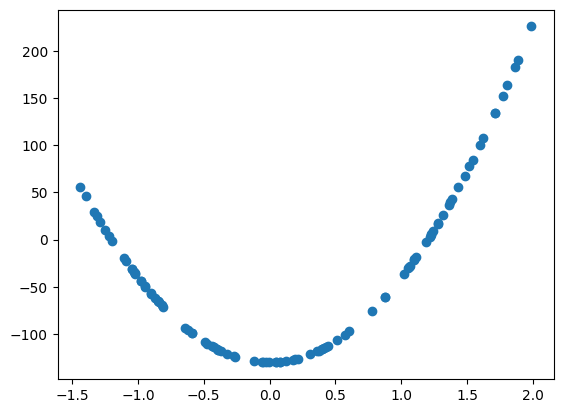

In [7]:
# scater plot of the data
plt.scatter(square_simple['x'], square_simple['y'])
square_simple

In [8]:
neural1 = NeuralNetwork([5], 1, 1)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])
neural1.train(square_simple["x"], square_simple["y"], learning_rate=0.01, batch_size_frac=0.5)
neural1.mean_squared_error(square_simple["x"], square_simple["y"])

KeyboardInterrupt: 

Layer number 0
Weights
[[-16.040207   -11.43956078  -6.08054423  -7.28785562  -9.05298728]]
biases
[[29.47087121 17.58866772 -5.44096437  5.16290323 10.65264015]]


Layer number 1
Weights
[[-91.65974949]
 [-91.53915153]
 [165.41572869]
 [-78.23763898]
 [-85.35096495]]
biases
[[222.68205994]]


None


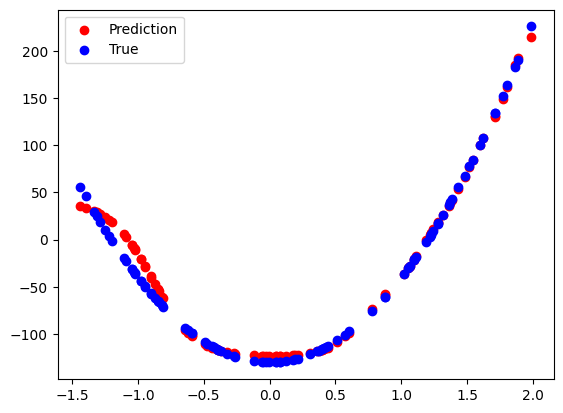

In [ ]:
y = []
for i in square_simple["x"]:
    y.append(neural1.forward(i))
plt.scatter(square_simple["x"], y, c="red")
plt.scatter(square_simple["x"], square_simple["y"], c="blue")
plt.legend(["Prediction", "True"])
print(neural1.visualize())

In [ ]:
neural2 = NeuralNetwork([10], 1, 1)
neural2.mean_squared_error(square_simple['x'], square_simple['y'])
neural2.train(square_simple["x"], square_simple["y"], learning_rate=0.002, batch_size_frac=0.05)
neural2.mean_squared_error(square_simple["x"], square_simple["y"])

In [ ]:
y = []
for i in square_simple["x"]:
    y.append(neural2.forward(i))
plt.scatter(square_simple["x"], y)

In [ ]:
neural3 = NeuralNetwork([5, 5], 1, 1)
neural3.mean_squared_error(square_simple['x'], square_simple['y'])
# neural3.train(square_simple["x"], square_simple["y"])
# neural3.mean_squared_error(square_simple["x"], square_simple["y"])

# Second set

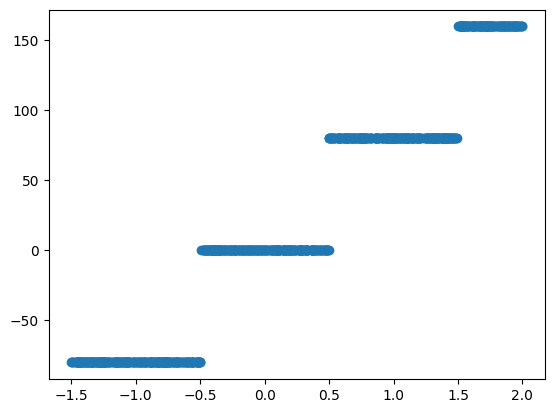

In [9]:
steps_large = pd.read_csv("../data/regression/steps-large-test.csv", index_col=0)
plt.scatter(steps_large["x"], steps_large["y"])

In [11]:
neural4 = NeuralNetwork([5], 1, 1)
neural4.mean_squared_error(steps_large["x"], steps_large["y"])
neural4.train(steps_large["x"], steps_large["y"],learning_rate=0.01, batch_size_frac=0.05)
neural4.mean_squared_error(steps_large["x"], steps_large["y"])

Current mean squared error: 134.73264358779008, counter: 1000
current momentum weights gradient: [[ 1.50002529  1.41595849  5.29566261 -0.83070955  0.93160365]]
Current mean squared error: 82.90001562996072, counter: 2000
current momentum weights gradient: [[-0.75528978 -0.67096497  5.61337588  2.19242091 -2.91126162]]
Current mean squared error: 66.71423396098737, counter: 3000
current momentum weights gradient: [[-1.64647286 -1.51534307  2.29160931  0.47648714 -0.56977956]]
Current mean squared error: 59.24706297072821, counter: 4000
current momentum weights gradient: [[ 0.25782829  0.25119479 -1.30542425 -0.07473273  0.26976715]]
Current mean squared error: 54.16008665504402, counter: 5000
current momentum weights gradient: [[-1.18639277 -1.0981846  -0.90446054 -0.56239093  0.7664729 ]]
Current mean squared error: 50.613620304467474, counter: 6000
current momentum weights gradient: [[ 1.47877416  1.40657011 -2.44477098 -0.36162552  0.58109648]]
Current mean squared error: 47.8545853

KeyboardInterrupt: 

Layer number 0
Weights
[[ 52.64285024  51.97131258 -55.00062805 -48.92323409  59.12913985]]
biases
[[-26.19108835 -25.85784996  81.92641043 -24.07690318  29.0957847 ]]


Layer number 1
Weights
[[ 40.95324853]
 [ 38.89802484]
 [-81.17674156]
 [-30.20278559]
 [ 50.25190205]]
biases
[[30.92492357]]


None


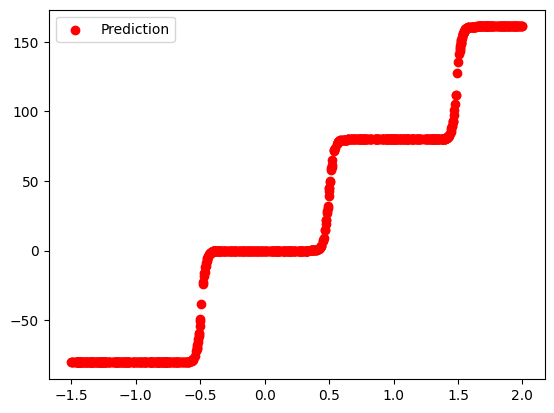

In [13]:
y = []
for i in steps_large["x"]:
    y.append(neural4.forward(i))
plt.scatter(steps_large["x"], y, c="red")
# plt.scatter(steps_large["x"], steps_large["y"], c="blue")
plt.legend(["Prediction", "True"])
print(neural4.visualize())

In [ ]:
neural5 = NeuralNetwork([10], 1, 1)
neural5.mean_squared_error(steps_large["x"], steps_large["y"])
# neural5.train(steps_large["x"], steps_large["y"])
# neural5.mean_squared_error(steps_large["x"], steps_large["y"])

In [ ]:
neural6 = NeuralNetwork([5,5], 1, 1)
neural6.mean_squared_error(steps_large["x"], steps_large["y"])